<a href="https://colab.research.google.com/github/nihermann/Pokemaenner/blob/main/ImageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import time
import PIL
from IPython import display
#if not already installed
!pip install -q git+https://github.com/tensorflow/docs 
import tensorflow_docs.vis.embed as embed


     |████████████████████████████████| 1.0MB 5.1MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# preparing the dataset
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/pokemaenner/data_white", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(lambda x: x / 255.0)

Found 10119 files belonging to 1 classes.


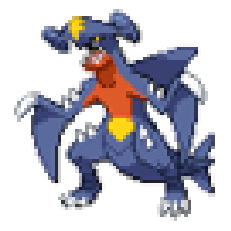

In [6]:
# displaying the data
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [23]:
# discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# generator
latent_dim = 50

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)            

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, checkpoint_path = "/content/drive/MyDrive/pokemaenner/model/training_1/cp.ckpt"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.checkpoint_path = checkpoint_path


    def on_epoch_end(self, epoch, logs=None):
        tf.keras.callbacks.ModelCheckpoint(filepath=self.checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            try:
              img.save("/content/drive/MyDrive/pokemaenner/results/generated_img_%03d_%d.png" % (epoch, i))
            except:
              img.save("/content/drive/MyDrive/pokemaenner/results")


In [ ]:
epochs = 2

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

In [34]:
new_model.save_weights("/content/drive/MyDrive/pokemaenner/model/gan_model", save_format='tf')

# Recreate the model
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Load the state of the old model
gan.load_weights('/content/drive/MyDrive/pokemaenner/model/gan_model')


In [ ]:
epochs = 100
new_model.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

Epoch 1/100
317/317 [==============================] - 210s 662ms/step - d_loss: 0.5699 - g_loss: 1.1675
Epoch 2/100
317/317 [==============================] - 214s 673ms/step - d_loss: 0.7314 - g_loss: 0.8900
Epoch 3/100
317/317 [==============================] - 212s 668ms/step - d_loss: 0.4116 - g_loss: 22.7893
Epoch 4/100
317/317 [==============================] - 214s 672ms/step - d_loss: 0.5896 - g_loss: 1.1880
Epoch 5/100
317/317 [==============================] - 212s 668ms/step - d_loss: 0.5567 - g_loss: 1.1655
Epoch 6/100
317/317 [==============================] - 214s 674ms/step - d_loss: 0.4798 - g_loss: 1.4150
Epoch 7/100
317/317 [==============================] - 210s 662ms/step - d_loss: 0.4698 - g_loss: 2.2026
Epoch 8/100
317/317 [==============================] - 213s 672ms/step - d_loss: 0.5052 - g_loss: 1.5084
Epoch 9/100
317/317 [==============================] - 212s 668ms/step - d_loss: 0.5374 - g_loss: 1.7603
Epoch 10/100
317/317 [==============================] 

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no, picture_number = 0):
  if epoch_no < 10:
    return PIL.Image.open(f'/content/drive/MyDrive/pokemaenner/results/generated_img_00{epoch_no}_{picture_number}.png')
  else:
    return PIL.Image.open(f'/content/drive/MyDrive/pokemaenner/results/generated_img_0{epoch_no}_{picture_number}.png')

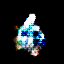

In [ ]:
display_image(49,7)

In [ ]:
def make_gif(epoch = 0):
  anim_file = f'/content/drive/MyDrive/pokemaenner/gifs/GAN_epoch_{epoch}.gif'

  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pokemaenner/results/generated_img_*[0-9]_[0-9].png')
    filenames = sorted(filenames)
    for filename in filenames:
      if epoch < 9:
        if "00"+str(epoch) in filename:
          image = imageio.imread(filename)
          writer.append_data(image)
      elif epoch > 9:
        if "0"+str(epoch) in filename:
          image = imageio.imread(filename)
          writer.append_data(image)
      elif epoch > 99:
        if str(epoch) in filename:
          image = imageio.imread(filename)
          writer.append_data(image)

  embed.embed_file(anim_file)

In [ ]:
for i in range(49):
  make_gif(i)